### **PMLDL Assignment 2:** Movie Review Sentiment Analysis

IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.

![alt text](https://www.samyzaf.com/ML/imdb/imdb2.png)

In this assignment we are interested in performing a sentiment analysis on the movie reviews. Your tasks are as following:

1. **Preprocess** the text and put it in appropriate format (cleaning, tokenization ... as seen in the lab) (20 points)
2. Implement **2 models** of your choice (with lstm's , RNN's ...) One with trainable embedding layer and in the second use embeddings from word2vec or Glov in the embedding layer ( you can use library such as gensim) (20 points)
3. **Compare** the performance of the two models (5 pts)
3. Use **TSNE** or **Umap** to vizualise words and their vectors in the latent space (of the trainable embedding)( 15 points)
4. **Report** metrics and loss using tensorbord/comet or any tool you are comfortable with.  (5 points)

Clean and documented code (10 points)             
Correct method (includes correct loss function , parameters tuning, correct training and testing, accuracy value) 25 points.



Remarks :


*   Use Pytorch
*   Unattached graphs are not counted (0 point)  
*   Cheating will result in a severe penalization
*   Plagiarism is prohibited




## Reading Data & Preprocessing

In [ ]:
import torch

# checking if GPU is available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda:1")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [ ]:
import pandas as pd
import numpy as np
# reading dataset from csv file downloaded from here: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df = pd.read_csv('imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
x = df['review'].values
y = df['sentiment'].values

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
import nltk.tokenize as tokenization

def clean_and_tokenize_text(text):

    text = text.lower() # lowercasing the text

    # cleaning the text from special for the domain but meaningless in terms of sentiment analysis symbols
    text = text.replace('<br /><br />', ' ')
    text = text.replace('\'', ' ')
    for symbol in '[/(){}\[\]\|@,;]':
        text = text.replace(symbol, '')

    # tokenizing the text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    text = tokenization.word_tokenize(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
for i in range(x.shape[0]):
    x[i] = clean_and_tokenize_text(x[i])

In [ ]:
for i in range(y.shape[0]):
    if y[i] == "positive":
        y[i] = 1
    else:
        y[i] = 0

## Prepare training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
# x_train1 and x_test1 are x_train and x_test modifications prepared specifically for the 1st model
x_train1 = tokenizer.texts_to_sequences(x_train)
x_test1 = tokenizer.texts_to_sequences(x_test)

In [ ]:
maxlen = 250 # only keep 250 words from each review; if there are less, use padding
x_train1 = pad_sequences(x_train1, maxlen=maxlen)
x_test1 = pad_sequences(x_test1, maxlen=maxlen)

In [ ]:
x_train1 = x_train1.astype('int32')
x_test1 = x_test1.astype('int32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data1 = TensorDataset(torch.from_numpy(x_train1), torch.from_numpy(y_train))
test_data1 = TensorDataset(torch.from_numpy(x_test1), torch.from_numpy(y_test))

batch_size = 50

train_loader1 = DataLoader(train_data1, shuffle=True, batch_size=batch_size)
test_loader1 = DataLoader(test_data1, shuffle=True, batch_size=batch_size)

In [ ]:
from gensim.models import Word2Vec
vector_size = 100 # size of embeddings
word2vec = Word2Vec(sentences = x, vector_size = vector_size)

In [ ]:
# use word2vec embeddings to transform dataset x
# pad each review to size maxlen
def padding_embeddings(x, word2vec, maxlen, vector_size):
    res = []
    for review_ind in range(len(x)):
        review_embedding = []
        for word_ind in range(len(x[review_ind])):
            if word_ind < maxlen:
                word = x[review_ind][word_ind]
                try:
                    review_embedding.append(word2vec.wv[word])
                except KeyError:
                    review_embedding.append([0] * vector_size)
        for i in range(maxlen - len(review_embedding)):
            review_embedding.append([0] * vector_size)
        res.append(review_embedding)
    return res

In [ ]:
# x_train2 and x_test2 are x_train and x_test modifications prepared specifically for the 2nd model
x_train2 = padding_embeddings(x_train, word2vec, 200, vector_size)
x_test2 = padding_embeddings(x_test, word2vec, 200, vector_size)

In [ ]:
x_train2 = np.array(x_train2, dtype = "float32")
x_test2 = np.array(x_test2, dtype = "float32")

In [ ]:
train_data2 = TensorDataset(torch.from_numpy(x_train2), torch.from_numpy(y_train))
test_data2 = TensorDataset(torch.from_numpy(x_test2), torch.from_numpy(y_test))

batch_size = 50

train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=batch_size)
test_loader2 = DataLoader(test_data2, shuffle=True, batch_size=batch_size)

## Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

EMBEDDING_DIM = 200
HIDDEN_DIM = 70
VOCAB_SIZE = len(tokenizer.word_index) + 1

class trainable_embedding_model(torch.nn.Module) :
    def __init__(self, embedding_dim, hidden_dim, vocab_size) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return torch.sigmoid(self.linear(ht[-1]))

    def return_embeddings(self, x):
        return self.embeddings(x)

In [ ]:
model1 = trainable_embedding_model(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model1.parameters(), lr = 0.1)

In [ ]:
class word2vec_model(torch.nn.Module) :
    def __init__(self, embedding_dim, hidden_dim) :
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return torch.sigmoid(self.linear(ht[-1]))

In [ ]:
model2 = word2vec_model(vector_size, 50)
optimizer2 = optim.Adam(model2.parameters(), lr = 0.0002)

## Train & Test



In [ ]:
def train(model, train_loader, optimizer):
    i = 0
    for sentence, label in train_loader:
        model.zero_grad()
        tag_scores = model(sentence)
        label = np.reshape(label, [batch_size, 1])
        loss = loss_function(tag_scores, label)
        loss.backward()
        optimizer.step()
        i += 50
        if i % 5000 == 0:
            print(str(i) + "/40000")


def test(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    with torch.no_grad():
        for x, y in valid_dl:
            y_hat = model(x)
            y = np.reshape(y, [batch_size, 1])
            loss = loss_function(y_hat, y)
            pred = torch.max(y_hat, 1)[1]
            total += y.shape[0]
            sum_loss += loss.item() * y.shape[0]
            for i in range(batch_size):
                if abs(y[i] - y_hat[i]) < 0.5:
                    correct += 1

    print("sum_loss:", sum_loss)
    print("accuracy:", correct/total)

In [ ]:
for epoch in range(7):
    print("epoch " + str(epoch + 1))
    train(model1, train_loader1, optimizer)
    test(model1, test_loader1)

epoch 1
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 6648.838910460472
accuracy: 0.5899
epoch 2
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 5837.502163648605
accuracy: 0.6802
epoch 3
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 4895.749546587467
accuracy: 0.7652
epoch 4
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 4383.436493575573
accuracy: 0.7986
epoch 5
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 5345.810254663229
accuracy: 0.7646
epoch 6
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 4091.991976648569
accuracy: 0.8198
epoch 7
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss:

In [ ]:
for epoch in range(7):
    print("epoch " + str(epoch + 1))
    train(model2, train_loader2, optimizer2)
    test(model2, test_loader2)

epoch 1
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 6846.103611588478
accuracy: 0.5229
epoch 2
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 5635.551688075066
accuracy: 0.7381
epoch 3
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 6063.335801661015
accuracy: 0.6652
epoch 4
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 5513.767635822296
accuracy: 0.7573
epoch 5
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 5595.515322685242
accuracy: 0.7369
epoch 6
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss: 6030.070298910141
accuracy: 0.6928
epoch 7
5000/40000
10000/40000
15000/40000
20000/40000
25000/40000
30000/40000
35000/40000
40000/40000
sum_loss:

## Visualizations

In [ ]:
# visualizing the trainable embeddings for the 20 most popular tokens using TSNE

import ast
tokenizer_config = tokenizer.get_config()
words_indices = ast.literal_eval(tokenizer_config["word_index"])
print(list(words_indices.items())[:10])

[('.', 1), ('movie', 2), ('film', 3), ("''", 4), ('``', 5), ('one', 6), ('!', 7), ('like', 8), ('?', 9), ('good', 10)]


In [ ]:
words_embeddings = {}
for word, index in list(words_indices.items())[:10000]:
    index = torch.tensor(index)
    embedding = model1.return_embeddings(index)
    words_embeddings[word] = embedding

In [ ]:
words = list(words_embeddings.keys())
embeddings = list(words_embeddings.values())

In [ ]:
for i in range(len(embeddings)):
    embeddings[i] = embeddings[i].tolist()
embeddings = np.array(embeddings)

In [ ]:
from sklearn.manifold import TSNE
squeezed_embeddings = TSNE(n_components=2).fit_transform(embeddings)

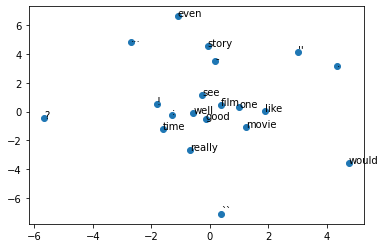

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.scatter(squeezed_embeddings[:20, 0], squeezed_embeddings[:20, 1])

for i, txt in enumerate(words[:20]):
    ax.annotate(words[i], (squeezed_embeddings[i][0], squeezed_embeddings[i][1]))